<a href="https://colab.research.google.com/github/TechDailyNotes/study-notes-triton/blob/main/triton_02_fused_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fused Softmax

## Motivations

In [1]:
pip install -U --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly

Looking in indexes: https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 MB 11.7 MB/s eta 0:00:00


In [2]:
import torch
import triton
import triton.language as tl
from triton.runtime import driver

def naive_softmax(x):
    # Step 1: Shift to prevent overflow.
    # MN reads, M writes
    x_max = x.max(dim=1)[0]
    # MN + M reads, MN writes
    z = x - x_max[:, None]

    # Step 2: Compute softmax.
    # MN reads, MN writes
    numerator = z.exp()
    # MN reads, M writes
    denominator = numerator.sum(dim=1)
    # MN + M reads, MN writes
    retval = numerator / denominator[:, None]
    # 5MN + 2M reads, 3MN + 2M writes
    return retval

## Compute Kernel

In [ ]:
@triton.jit
def softmax_kernel(input_ptr, output_ptr, n_rows, n_cols,
                   input_row_stride, output_row_stride,
                   BLOCK_SIZE: tl.constexpr, num_stages: tl.constexpr):
    # Step 1: Get kernel parameters.
    row_index_start = tl.program_id(0)
    row_index_end = n_rows
    row_index_step = tl.num_programs(0)

    for row_index in tl.range(row_index_start, row_index_end, row_index_step,
                              num_stages=num_stages):
        # Step 2: Load data.
        input_start_ptr = input_ptr + row_index * input_row_stride
        input_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = input_start_ptr + input_offsets
        input_mask = input_offsets < n_cols
        input_row = tl.load(input_ptrs, mask=input_mask, other=-float("inf"))

        # Step 3: Compute data.
        input_row_ = input_row - tl.max(input_row, axis=0)
        numerator = tl.exp(input_row_)
        denominator = tl.sum(numerator, axis=0)
        output_row = numerator / denominator

        # Step 4: Store data.
        output_start_ptr = output_ptr + row_index * output_row_stride
        output_offsets = tl.arange(0, BLOCK_SIZE)
        output_ptrs = output_start_ptr + output_offsets
        output_mask = output_offsets < n_cols
        tl.store(output_ptrs, output_row, mask=output_mask)

In [ ]:
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
MAX_SHARED_MEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
MAX_NUM_REGS = properties["max_num_regs"]
SM_COUNT = properties["multiprocessor_count"]
target = triton.runtime.driver.active.get_current_target()

def softmax(x):
    # Step 1: Init output.
    y = torch.empty_like(x)

    # Step 2: Set kernel parameters.
    n_rows, n_cols = x.shape

    BLOCK_SIZE = triton.next_power_of_2(n_cols)
    num_stages = 4 if MAX_SHARED_MEM > 200000 else 2
    num_warps = 8

    kernels = {}

    # Step 3: Launch kernel function.
    kernel, n_programs = kernels.get(BLOCK_SIZE, (None, 0))

    if kernel is None:
        kernel = softmax_kernel.warmup(x, y, n_rows, n_cols,
                                       x.stride(0), y.stride(0),
                                       BLOCK_SIZE=BLOCK_SIZE,
                                       num_stages=num_stages,
                                       num_warps=num_warps, grid=(1, ))
        kernel._init_handles()

        occupancy = min(MAX_NUM_REGS // (num_warps * WARP_SIZE * kernel.n_regs),
                        MAX_SHARED_MEM // kernel.metadata.shared)
        n_programs = SM_COUNT * occupancy

        kernels[BLOCK_SIZE] = (kernel, n_programs)

    n_programs = min(n_programs, n_rows)

    kernel[(n_programs, 1, 1)](x, y, n_rows, n_cols, x.stride(0), y.stride(0))

    # Step 4: Return output.
    return y

## Unit Test

In [ ]:
torch.manual_seed(0)
x = torch.randn((1823, 781), dtype=torch.float32, device="cuda")
output_triton = softmax(x)
output_torch = torch.softmax(x, axis=1)
assert torch.allclose(output_triton, output_torch), (output_triton, output_torch)
print(f"Max diff is {torch.max(torch.abs(output_triton - output_torch))}.")

Max diff is 7.450580596923828e-09.


## Benchmark

# Practice

## Motivations

In [2]:
import torch
import triton
import triton.language as tl
from triton.runtime import driver

def prac_naive_softmax(x):
    # Step 1: Shift to prevent overflow.
    x_shift = x - x.max(dim=1)[0][:, None]

    # Step 2: Compute softmax.
    numerator = x.exp()
    denominator = numerator.sum(dim=1)
    retval = numerator / denominator[:, None]
    return retval

## Compute Kernel

In [3]:
@triton.jit
def prac_softmax_kernel(input_ptr, output_ptr, num_rows, num_cols,
                        input_row_stride, output_row_stride,
                        BLOCK_SIZE: tl.constexpr, num_stages: tl.constexpr):
    # Step 1: Get the thread parameter.
    row_index_start = tl.program_id(0)
    row_index_end = num_rows
    row_index_step = tl.num_programs(0)

    for row_index in tl.range(row_index_start, row_index_end, row_index_step,
                              num_stages=num_stages):
        # Step 2: Load data.
        input_ptr_start = input_ptr + row_index * input_row_stride
        input_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = input_ptr_start + input_offsets
        input_mask = input_offsets < num_cols
        input_row = tl.load(input_ptrs, mask=input_mask, other=float("-inf"))

        # Step 3: Compute data.
        input_row_shift = input_row - tl.max(input_row, axis=0)
        numerator = tl.exp(input_row_shift)
        denominator = tl.sum(numerator, axis=0)
        output_row = numerator / denominator

        # Step 4: Store data.
        output_ptr_start = output_ptr + row_index * output_row_stride
        output_offsets = tl.arange(0, BLOCK_SIZE)
        output_ptrs = output_ptr_start + output_offsets
        output_mask = output_offsets < num_cols
        tl.store(output_ptrs, output_row, mask=output_mask)

In [4]:
prac_device = torch.cuda.current_device()
prac_properties = driver.active.utils.get_device_properties(prac_device)
MAX_SHARED_MEM = prac_properties["max_shared_mem"]
MAX_NUM_REGS = prac_properties["max_num_regs"]
WARP_SIZE = prac_properties["warpSize"]
SM_COUNT = prac_properties["multiprocessor_count"]

kernels = {}

def prac_softmax(x):
    # Step 1: Init output.
    y = torch.empty_like(x)

    # Step 2: Set kernel parameters.
    num_rows, num_cols = x.shape
    BLOCK_SIZE = triton.next_power_of_2(num_cols)
    num_stages = 4 if MAX_SHARED_MEM > 200000 else 2
    num_warps = 8

    # Step 3: Launch kernel function.
    kernel, num_programs = kernels.get(BLOCK_SIZE, (None, 0))

    if kernel is None:
        kernel = prac_softmax_kernel.warmup(x, y, num_rows, num_cols,
                                            x.stride(0), y.stride(0),
                                            BLOCK_SIZE=BLOCK_SIZE,
                                            num_stages=num_stages,
                                            num_warps=num_warps, grid=(1, ))
        kernel._init_handles()
        occupancy = min(MAX_NUM_REGS // (num_warps * WARP_SIZE * kernel.n_regs),
                        MAX_SHARED_MEM // kernel.metadata.shared)
        num_programs = SM_COUNT * occupancy
        kernels[BLOCK_SIZE] = (kernel, num_programs)

    num_programs = min(num_programs, num_rows)

    kernel[(num_programs, 1, 1)](x, y, num_rows, num_cols,
                                 x.stride(0), y.stride(0))

    # Step 4: Return output.
    return y

## Unit Test

In [5]:
torch.manual_seed(0)
x = torch.randn((1823, 781), dtype=torch.float32, device="cuda")
output_triton = prac_softmax(x)
output_torch = torch.softmax(x, axis=1)
assert torch.allclose(output_triton, output_torch), (output_triton, output_torch)
print(f"max diff = {torch.max(torch.abs(output_triton - output_torch))}")

max diff = 7.450580596923828e-09


## Benchmark

In [6]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"], x_vals=[128 * i for i in range(2, 100)],
        line_arg="provider", line_vals = ["triton", "torch"],
        line_names=["Triton", "Torch"], styles=[("blue", "-"), ("green", "-")],
        ylabel="GB/s", plot_name="Fused Softmax Performance", args={"M": 4096},
    )
)
def benchmark(M, N, provider):
    # Step 1: Init input.
    x = torch.randn((M, N), dtype=torch.float32, device="cuda")

    # Step 2: Set benchmark parameters.
    quantiles = [0.5, 0.2, 0.8]

    # Step 3: Launch benchmark function.
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: prac_softmax(x),
                                                     quantiles=quantiles)
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=1),
                                                     quantiles=quantiles)

    # Step 4: Compute throughput.
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(min_ms), gbps(max_ms)

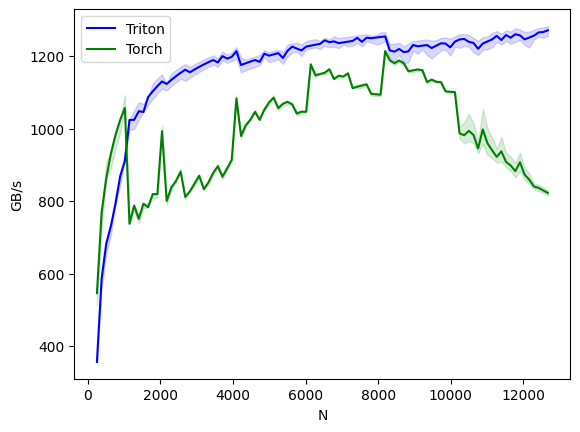

Fused Softmax Performance:
          N       Triton        Torch
0     256.0   356.173905   546.133347
1     384.0   585.142862   768.000002
2     512.0   682.666643   862.315828
3     640.0   731.428561   930.909084
4     768.0   792.774204   983.040025
5     896.0   868.848478  1023.999986
6    1024.0   910.222190  1057.032272
7    1152.0  1023.999964   737.280019
8    1280.0  1024.000026   787.692317
9    1408.0  1047.813953   750.933352
10   1536.0  1045.787204   792.774204
11   1664.0  1086.693913   783.058810
12   1792.0  1102.769243   819.199978
13   1920.0  1117.090900   819.199961
14   2048.0  1129.931006   992.969689
15   2176.0  1123.096789   800.367813
16   2304.0  1134.276920   837.818175
17   2432.0  1144.470568   855.208775
18   2560.0  1153.802781   880.860193
19   2688.0  1162.378328   811.471702
20   2816.0  1155.282091   826.715592
21   2944.0  1163.061753   848.720712
22   3072.0  1170.285724   869.946888
23   3200.0  1177.011490   832.520290
24   3328.0  1183.28887

In [7]:
benchmark.run(show_plots=True, print_data=True)